In [1]:
import datetime
print(datetime.datetime.now().isoformat())

2016-09-06T17:39:51.146021


# Is there a cutoff in Dst that allows slot filling?



## Method
Using a statistical model of the relationship between the slot filling at 464keV vs Dst. 

We model the number of slot filling events as a random sample from a binomial distribution meaning that there is a probability of the event occuring and there may be a parameter that changes the probability. This is not meant as a correlation but as a success failure creiteria. 

From Wikipedia:
In probability theory and statistics, the binomial distribution with parameters n and p is the discrete probability distribution of the number of successes in a sequence of n independent yes/no experiments, each of which yields success with probability p.





$
change \sim Bin(n,p) \\
logit(p) = \alpha + \beta x \\
a \sim N(0,5) \\
\beta \sim N(0,10)
$


where we set vague priors for $\alpha$ and $\beta$, the parameters for the logistic model.

This is the same technique used in the estimation of deaths due to a concentration of a chemical.

In [5]:
# http://onlinelibrary.wiley.com/doi/10.1002/2016JA022652/epdf


import pymc3
import tqdm
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import spacepy.plot as spp
import seaborn as sns
sns.set(font_scale=1.5)

Data delivered by Geoff Reeves 9/6/2016

In [6]:
# min_Dst, min_L
data = np.asarray([
65.000, 3.8000,  
50.000, 3.7000,
67.000, 3.5000,
61.000, 3.4000, 
77.000, 3.2000,
99.000, 2.8900,  
87.000, 2.8000,  
98.000, 2.8000, 
96.000, 2.8000,
93.000, 2.3000,
92.000, 2.3000, 
225.00, 2.3000, 
206.00, 2.3000,
125.00, 2.3000]).reshape((-1,2))

dst = data[:,0]
minL = data[:,1]
print(dst, minL, data.dtype)
                         
                         

[ 65.  50.  67.  61.  77.  99.  87.  98.  96.  93.  92. 225. 206. 125.] [3.8  3.7  3.5  3.4  3.2  2.89 2.8  2.8  2.8  2.3  2.3  2.3  2.3  2.3 ] float64


In [39]:
# make bins in Dst
dst_bins = np.arange(25, 300, 10)
print(dst_bins)
dst_bins_centers = np.asarray([dst_bins[:-1] + np.diff(dst_bins)/2]).T[:,0]
print(dst_bins_centers, dst_bins_centers.shape)
n_events_dig = np.digitize(dst, dst_bins)
print(n_events_dig)
n_events = np.zeros(len(dst_bins)-1)
success = np.zeros_like(n_events)
for i, v in enumerate(np.unique(n_events_dig)):
    n_events[v-1] = np.sum(n_events_dig==v)
    success[v-1] = np.sum(minL[n_events_dig==v] <= 2.4)
print(n_events)
print(success)

[ 25  35  45  55  65  75  85  95 105 115 125 135 145 155 165 175 185 195
 205 215 225 235 245 255 265 275 285 295]
[ 30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160.
 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270. 280. 290.] (27,)
[ 5  3  5  4  6  8  7  8  8  7  7 21 19 11]
[0. 0. 1. 1. 2. 1. 3. 3. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0.]


Text(0,0.5,'Min L Shell')

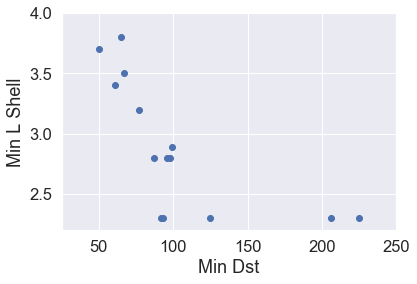

In [40]:
plt.plot(dst, minL, 'o')
plt.xlim((25, 250))
plt.ylim((2.2, 4.0))
plt.xlabel('Min Dst')
plt.ylabel('Min L Shell')

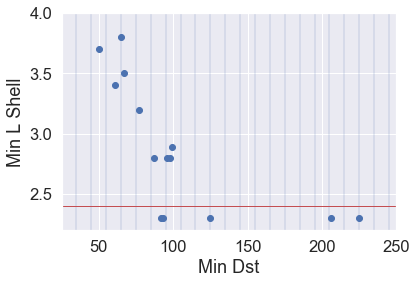

In [41]:
plt.plot(dst, minL, 'o')
plt.xlim((25, 250))
plt.ylim((2.2, 4.0))
plt.xlabel('Min Dst')
plt.ylabel('Min L Shell')
for v in dst_bins:
    plt.axvline(v, lw=0.25)
plt.axhline(2.4, c='r', lw=1)

## Oberved Data:
* n_pts : the number of points in each of the 10nT wide Dst bins
* successes : the number of events in each bin where the slot was filled (Min L = 2.3)
* dst_bins_centers : the centers of the Dst bins

Setup the Bayesian model accorind to the description above. Run the Markov chain monte carlo (MCMC) to sample the posterior distributions for $\alpha$ and $\beta$

In [42]:
ind = n_events > 0

for i, j in zip(success[ind], n_events[ind]):
    print(i,j)

0.0 1.0
0.0 1.0
0.0 2.0
0.0 1.0
2.0 3.0
0.0 3.0
1.0 1.0
1.0 1.0
1.0 1.0


In [69]:
# define priors
# these are wide uninformative priors
# alpha = pymc.Normal('alpha', mu=0, tau=1.0/5**2)
# beta = pymc.Normal('beta', mu=0, tau=1.0/10**2)
with pymc3.Model() as model:
    alpha = pymc3.Uniform('alpha', -100, 100)
    beta = pymc3.Uniform('beta', -100, 100)

    # cannot feed in zero events
    ind = n_events > 0

    # define likelihood
    p = pymc3.math.invlogit(alpha + beta*dst_bins_centers[ind])
    y = pymc3.Binomial('y_obs', n=n_events[ind], p=p, observed=success[ind])
    step = pymc3.Metropolis([alpha, beta])
    trace = pymc3.sample(10000, njobs=5, tune=5000, step=step)


Multiprocess sampling (5 chains in 5 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 5 chains: 100%|██████████| 75000/75000 [00:14<00:00, 5221.76draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


Make diagnostic plots of the posteriour distributions as created using MCMC.  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124888c18>,
      dtype=object)

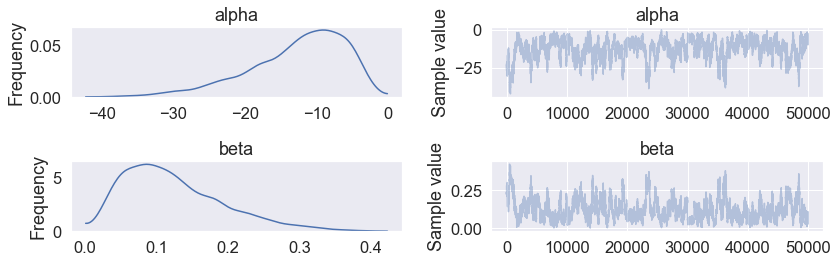

In [70]:
pymc3.traceplot(trace, combined=True)

In [71]:
pymc3.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-12.720232,6.765325,0.534437,-26.486792,-2.241554,91.192343,1.020307
beta,0.123690,0.070100,0.005546,0.015498,0.264355,90.552415,1.020122


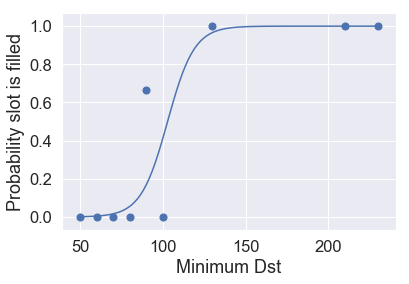

In [72]:
xp = np.linspace(dst_bins_centers[ind].min(), dst_bins_centers[ind].max(), 100)
a = trace['alpha'].mean()
b = trace['beta'].mean()
y_val = pymc3.math.invlogit(a + b*xp).eval()
plt.plot(xp, y_val)
plt.scatter(dst_bins_centers[ind], success[ind]/n_events[ind], s=50);
plt.xlabel('Minimum Dst')
plt.ylabel('Probability slot is filled')
plt.gca().ticklabel_format(useOffset=False)


## Predictions based on this model

In [73]:
# get the minimum Dst where 99% should be successes
for percentage in [50,75,90,95,99]:
    ind99 = y_val >= percentage/100
    minDst99 = xp[ind99][0]
    print('At a minimum Dst of {0:0.0f}nT it is predicted to have a {1}% percent of a slot filling at this energy'.format(minDst99, percentage))

At a minimum Dst of 105nT it is predicted to have a 50% percent of a slot filling at this energy
At a minimum Dst of 112nT it is predicted to have a 75% percent of a slot filling at this energy
At a minimum Dst of 121nT it is predicted to have a 90% percent of a slot filling at this energy
At a minimum Dst of 128nT it is predicted to have a 95% percent of a slot filling at this energy
At a minimum Dst of 141nT it is predicted to have a 99% percent of a slot filling at this energy


## Plot up many lines for a feel at uncertantity

In [78]:
pymc3.math.invlogit(trace['alpha'][4] + trace['beta'][4]*xp).eval()

array([1.25716402e-05, 1.93489333e-05, 2.97797142e-05, 4.58333478e-05,
       7.05405559e-05, 1.08565138e-04, 1.67083283e-04, 2.57135424e-04,
       3.95703361e-04, 6.08898818e-04, 9.36851207e-04, 1.44118376e-03,
       2.21640996e-03, 3.40721472e-03, 5.23444368e-03, 8.03368400e-03,
       1.23113565e-02, 1.88235270e-02, 2.86803263e-02, 4.34698934e-02,
       6.53726998e-02, 9.71901546e-02, 1.42138349e-01, 2.03195401e-01,
       2.81862675e-01, 3.76591664e-01, 4.81798125e-01, 5.88643592e-01,
       6.87737158e-01, 7.72197623e-01, 8.39156123e-01, 8.89255924e-01,
       9.25142656e-01, 9.50053425e-01, 9.66970435e-01, 9.78288561e-01,
       9.85785357e-01, 9.90718126e-01, 9.93949630e-01, 9.96060553e-01,
       9.97436892e-01, 9.98333179e-01, 9.98916386e-01, 9.99295678e-01,
       9.99542269e-01, 9.99702551e-01, 9.99806719e-01, 9.99874411e-01,
       9.99918398e-01, 9.99946979e-01, 9.99965550e-01, 9.99977617e-01,
       9.99985457e-01, 9.99990551e-01, 9.99993861e-01, 9.99996011e-01,
      

array([-23.14207014, -23.14207014, -23.14207014, ...,  -7.15932027,
        -7.15932027,  -7.15932027])

In [90]:
# one should be able to get estimates of the line uncertainity
ilu = np.empty((1000, len(xp)), dtype=float)
ilu = []
for ii, v in tqdm.tqdm(enumerate(np.random.randint(0, len(trace['alpha']), 100)), total=100):
    if trace['alpha'][v] == 0:
        continue
    if trace['beta'][v] == 0:
        continue
        
    ilu.append(pymc3.math.invlogit(trace['alpha'][v] + trace['beta'][v]*xp).eval())
ilu=np.asarray(ilu)
ilu.shape


  0%|          | 0/100 [00:00<?, ?it/s]INFO (theano.gof.compilelock): Refreshing lock /Users/balarsen/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir/lock

100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


(100, 100)

Text(0,0.5,'Probability slot is filled')

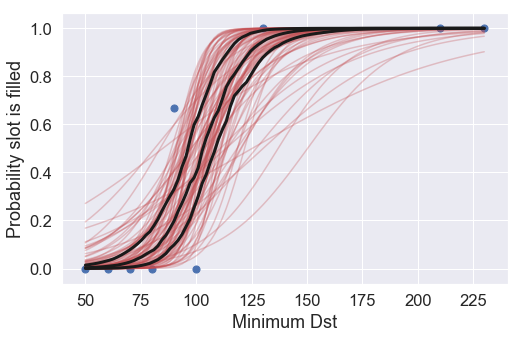

In [95]:
plt.figure(figsize=(8,5))
xp = np.linspace(dst_bins_centers[ind].min(), dst_bins_centers[ind].max(), 100)
for v in ilu:
    plt.plot(xp, v, alpha=.3, c='r')

plt.plot(xp, np.percentile(ilu, [25, 50, 75],axis=0).T, c='k', lw=3)
    
# a = trace['alpha'].mean()
# b = trace['beta'].mean()
# plt.plot(xp, invlogit(a + b*xp).value)

# a = trace['alpha'].stats()['quantiles'][50]
# b = trace['beta'].stats()['quantiles'][50]
# plt.plot(xp, invlogit(a + b*xp).value, c='y')


plt.scatter(dst_bins_centers[ind], success[ind]/n_events[ind], s=50);
plt.xlabel('Minimum Dst')
plt.ylabel('Probability slot is filled')

Same as previous figure with the red lines overlayed as 100 joint draws from the model posterior in order to show spread. 

In [98]:
xp.shape, np.percentile(ilu, [25, 50, 75],axis=0).T.shape

((100,), (100, 3))

In [109]:
ii50 = np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,0] > 0.5)[0]
ii75 = np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,0] > 0.75)[0]
ii90 = np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,0] > 0.90)[0]
ii95 = np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,0] > 0.95)[0]
ii99 = np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,0] > 0.99)[0]

In [110]:
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 50% percent of a slot filling at this energy'.format(xp[ii50[0]]))
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 75% percent of a slot filling at this energy'.format(xp[ii75[0]]))
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 90% percent of a slot filling at this energy'.format(xp[ii90[0]]))
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 95% percent of a slot filling at this energy'.format(xp[ii95[0]]))
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 99% percent of a slot filling at this energy'.format(xp[ii99[0]]))


At a minimum Dst of 110nT it is predicted to have a 50% percent of a slot filling at this energy
At a minimum Dst of 121nT it is predicted to have a 75% percent of a slot filling at this energy
At a minimum Dst of 134nT it is predicted to have a 90% percent of a slot filling at this energy
At a minimum Dst of 143nT it is predicted to have a 95% percent of a slot filling at this energy
At a minimum Dst of 166nT it is predicted to have a 99% percent of a slot filling at this energy


In [111]:
ii50 = np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,1] > 0.5)[0]
ii75 = np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,1] > 0.75)[0]
ii90 = np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,1] > 0.90)[0]
ii95 = np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,1] > 0.95)[0]
ii99 = np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,1] > 0.99)[0]
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 50% percent of a slot filling at this energy'.format(xp[ii50[0]]))
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 75% percent of a slot filling at this energy'.format(xp[ii75[0]]))
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 90% percent of a slot filling at this energy'.format(xp[ii90[0]]))
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 95% percent of a slot filling at this energy'.format(xp[ii95[0]]))
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 99% percent of a slot filling at this energy'.format(xp[ii99[0]]))


At a minimum Dst of 105nT it is predicted to have a 50% percent of a slot filling at this energy
At a minimum Dst of 114nT it is predicted to have a 75% percent of a slot filling at this energy
At a minimum Dst of 125nT it is predicted to have a 90% percent of a slot filling at this energy
At a minimum Dst of 132nT it is predicted to have a 95% percent of a slot filling at this energy
At a minimum Dst of 148nT it is predicted to have a 99% percent of a slot filling at this energy


In [112]:
ii50 = np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,2] > 0.5)[0]
ii75 = np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,2] > 0.75)[0]
ii90 = np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,2] > 0.90)[0]
ii95 = np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,2] > 0.95)[0]
ii99 = np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,2] > 0.99)[0]
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 50% percent of a slot filling at this energy'.format(xp[ii50[0]]))
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 75% percent of a slot filling at this energy'.format(xp[ii75[0]]))
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 90% percent of a slot filling at this energy'.format(xp[ii90[0]]))
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 95% percent of a slot filling at this energy'.format(xp[ii95[0]]))
print('At a minimum Dst of {0:0.0f}nT it is predicted to have a 99% percent of a slot filling at this energy'.format(xp[ii99[0]]))


At a minimum Dst of 97nT it is predicted to have a 50% percent of a slot filling at this energy
At a minimum Dst of 106nT it is predicted to have a 75% percent of a slot filling at this energy
At a minimum Dst of 115nT it is predicted to have a 90% percent of a slot filling at this energy
At a minimum Dst of 119nT it is predicted to have a 95% percent of a slot filling at this energy
At a minimum Dst of 130nT it is predicted to have a 99% percent of a slot filling at this energy


In [116]:
v50 = [xp[np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,2] > 0.5)[0][0]], 
       xp[np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,1] > 0.5)[0][0]], 
       xp[np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,0] > 0.5)[0][0]]]
v75 = [xp[np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,2] > 0.75)[0][0]], 
       xp[np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,1] > 0.75)[0][0]], 
       xp[np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,0] > 0.75)[0][0]]]
       
v90 = [xp[np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,2] > 0.90)[0][0]], 
       xp[np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,1] > 0.90)[0][0]], 
       xp[np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,0] > 0.90)[0][0]]]
v95 = [xp[np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,2] > 0.95)[0][0]], 
       xp[np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,1] > 0.95)[0][0]], 
       xp[np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,0] > 0.95)[0][0]]]
       
v99 = [xp[np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,2] > 0.99)[0][0]], 
       xp[np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,1] > 0.99)[0][0]], 
       xp[np.where(np.percentile(ilu, [25, 50, 75],axis=0).T[:,0] > 0.99)[0][0]]]
       

In [117]:
v50, v75, v90, v95, v99

([97.27272727272728, 104.54545454545455, 110.0],
 [106.36363636363636, 113.63636363636363, 120.9090909090909],
 [115.45454545454545, 124.54545454545455, 133.63636363636363],
 [119.0909090909091, 131.8181818181818, 142.72727272727272],
 [130.0, 148.1818181818182, 166.36363636363637])

In [129]:
print("a 50% probability of slot filling for {0:.0f}<dst<{1:.0f}".format(v50[0], v50[2]))
print("a 75% probability of slot filling for {0:.0f}<dst<{1:.0f}".format(v75[0], v75[2]))
print("a 90% probability of slot filling for {0:.0f}<dst<{1:.0f}".format(v90[0], v90[2]))
print("a 95% probability of slot filling for {0:.0f}<dst<{1:.0f}".format(v95[0], v95[2]))
print("a 99% probability of slot filling for {0:.0f}<dst<{1:.0f}".format(v99[0], v99[2]))

a 50% probability of slot filling for 97<dst<110
a 75% probability of slot filling for 106<dst<121
a 90% probability of slot filling for 115<dst<134
a 95% probability of slot filling for 119<dst<143
a 99% probability of slot filling for 130<dst<166


array([[ 7.27272727,  5.45454545],
       [ 7.27272727,  7.27272727],
       [ 9.09090909,  9.09090909],
       [12.72727273, 10.90909091],
       [18.18181818, 18.18181818]])